In [28]:
import string

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import pandas as pd

from tqdm import tqdm
tqdm.pandas()

import joblib

In [52]:
df = pd.read_csv("/content/drive/MyDrive/Colab/ethnicolor/data/census_2010_processed.csv")

In [71]:
df.shape

(162253, 14)

In [72]:
df['name'] = df['name'].str.replace("[^a-zA-Z' -]", '', regex=True)
df['name'] = df['name'].str.strip()
df['name'] = df['name'].str.title()
df.drop(df[df['name'].isna()].index, inplace=True)
df.reset_index(drop=True, inplace=True)

In [73]:
df.head()

,Unnamed: 0,name,rank,count,prop100k,cum_prop100k,pctwhite,pctblack,pctapi,pctaian,pct2prace,pcthispanic,argmax,ethni_act
0,0,Smith,1,2442977,828.19,828.19,70.90,23.11,0.50,0.89,2.19,2.40,pctwhite,nh_white
1,1,Johnson,2,1932812,655.24,1483.42,58.97,34.63,0.54,0.94,2.56,2.36,pctwhite,nh_white
2,2,Williams,3,1625252,550.97,2034.39,45.75,47.68,0.46,0.82,2.81,2.49,pctblack,nh_black
3,3,Brown,4,1437026,487.16,2521.56,57.95,35.60,0.51,0.87,2.55,2.52,pctwhite,nh_white
4,4,Jones,5,1425470,483.24,3004.80,55.19,38.48,0.44,1.00,2.61,2.29,pctwhite,nh_white


In [74]:
df.shape

(162252, 14)

In [75]:
vectorizer = joblib.load('/content/drive/MyDrive/Colab/ethnicolor/models_v2/lstm/pt_vec_lastname.joblib')


In [76]:
max_name = 30
all_categories =  ['asian', 'hispanic', 'nh_black', 'nh_white', 'other']
n_categories = len(all_categories)

vocab = list(vectorizer.get_feature_names_out())
all_letters = ''.join(vocab)
n_letters = len(vocab)
oob = n_letters + 1
vocab_size = oob + 1

In [77]:
# A custom Dataset class must implement three functions: __init__, __len__, and __getitem__

class EthniColorDataset(Dataset):
  def __init__(self, data_df, transform=None):
    self.df = data_df
    self.transform = transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    name = self.df.iloc[idx, df.columns.get_loc('name')]
    if self.transform:
      name_ids = self.transform(name)
    return name, name_ids

In [78]:
def letterToIndex(letter):
    return all_letters.find(letter)

def lineToTensor(line):
    # if name is more than max_name
    if len(line) > max_name:
      line = line[:max_name]
    tensor = torch.ones(max_name) * oob
    for li, letter in enumerate(line):
        tensor[li] = letterToIndex(letter)
    return tensor

In [79]:
dataset = EthniColorDataset(df, lineToTensor)

In [80]:
for i in range(3):
  name, ids  = dataset[i]
  print(i, name, ids)

0 Smith tensor([21., 41., 37., 48., 36., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56.])
1 Johnson tensor([12., 43., 36., 42., 47., 43., 42., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56.])
2 Williams tensor([25., 37., 40., 40., 37., 29., 41., 47., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56.])


In [81]:
import os

batch_size=1024

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=os.cpu_count())

In [82]:
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, len(sample_batched[0]), sample_batched[1].size())
    if i_batch == 2:
        break

0 1024 torch.Size([1024, 30])
1 1024 torch.Size([1024, 30])
2 1024 torch.Size([1024, 30])


In [83]:
# Set the random seed for reproducible results
torch.manual_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # The nn.Embedding layer returns a new tensor with dimension (sequence_length, 1, hidden_size)
        self.embedding = nn.Embedding(input_size, hidden_size)
        # LSTM layer expects a tensor of dimension (batch_size, sequence_length, hidden_size).
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        embedded = self.embedding(input.type(torch.IntTensor).to(input.device))
        # embedded = embedded.view(embedded.shape[0],-1,embedded.shape[3])
        h0 = torch.zeros(self.num_layers, embedded.size(0), self.hidden_size).to(input.device)
        c0 = torch.zeros(self.num_layers, embedded.size(0), self.hidden_size).to(input.device)
        out, _ = self.lstm(embedded, (h0, c0))
        out = out[:, -1, :]  # get the output of the last time step
        out = self.fc(out)
        out = self.softmax(out)
        return out


n_hidden = 256
seq_len = max_name

model = LSTM(vocab_size, n_hidden, n_categories, num_layers=2)
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab/ethnicolor/models_v2/lstm/lstm_lastname.pt', map_location=device))
model.to(device)

LSTM(
  (embedding): Embedding(57, 256)
  (lstm): LSTM(256, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [84]:
# Set the model to evaluation mode
model.eval()

# Disable gradient calculations
with torch.no_grad():
    # List to hold the predictions
    predictions = []
    names = []

    # Loop over the batches
    for batch in tqdm(dataloader):
        # Move the batch to the device the model is on
        nms = list(batch[0])
        tns = batch[1].to(device)
        # Compute the predictions
        outputs = model(tns)
        outputs = torch.argmax(outputs, dim=1)
        # Move the predictions to the CPU and convert to numpy arrays
        outputs = outputs.cpu().numpy()
        # Append the predictions to the list
        predictions.extend(list(outputs))
        names.extend(nms)

100%|██████████| 158/158 [00:03<00:00, 42.81it/s]


In [87]:
results_df = pd.DataFrame({'names': names, 'predictions':predictions})

In [88]:
results_df.head()

,names,predictions
0,Puhl,3
1,Waibel,3
2,Izazaga,1
3,Oatley,3
4,Glaza,3


In [89]:
results_df['preds'] = results_df['predictions'].apply(lambda x: all_categories[x])

In [90]:
results_df.head()

,names,predictions,preds
0,Puhl,3,nh_white
1,Waibel,3,nh_white
2,Izazaga,1,hispanic
3,Oatley,3,nh_white
4,Glaza,3,nh_white


In [91]:
results_df.shape

(161792, 3)

In [92]:
results_df['preds'].value_counts()

nh_white    145408
hispanic      7895
asian         4715
nh_black      3509
other          265
Name: preds, dtype: int64

In [93]:
res_dict = results_df['preds'].value_counts().to_dict()

In [97]:
# prompt: Merge df and results_df based on name and names column

merged_df = df.merge(results_df, left_on='name', right_on='names')
merged_df.head()


,Unnamed: 0,name,rank,count,prop100k,cum_prop100k,pctwhite,pctblack,pctapi,pctaian,pct2prace,pcthispanic,argmax,ethni_act,names,predictions,preds
0,0,Smith,1,2442977,828.19,828.19,70.90,23.11,0.50,0.89,2.19,2.40,pctwhite,nh_white,Smith,3,nh_white
1,1,Johnson,2,1932812,655.24,1483.42,58.97,34.63,0.54,0.94,2.56,2.36,pctwhite,nh_white,Johnson,3,nh_white
2,2,Williams,3,1625252,550.97,2034.39,45.75,47.68,0.46,0.82,2.81,2.49,pctblack,nh_black,Williams,2,nh_black
3,3,Brown,4,1437026,487.16,2521.56,57.95,35.60,0.51,0.87,2.55,2.52,pctwhite,nh_white,Brown,3,nh_white
4,4,Jones,5,1425470,483.24,3004.80,55.19,38.48,0.44,1.00,2.61,2.29,pctwhite,nh_white,Jones,3,nh_white


In [98]:
print(df.shape)
print(results_df.shape)
print(merged_df.shape)

(162252, 14)
(161792, 3)
(161792, 17)


              precision    recall  f1-score   support

       asian       0.82      0.42      0.55      9216
    hispanic       0.81      0.58      0.67     11131
    nh_black       0.57      0.25      0.35      7812
    nh_white       0.90      0.98      0.94    132823
       other       0.00      0.00      0.00       810

    accuracy                           0.88    161792
   macro avg       0.62      0.45      0.50    161792
weighted avg       0.87      0.88      0.87    161792



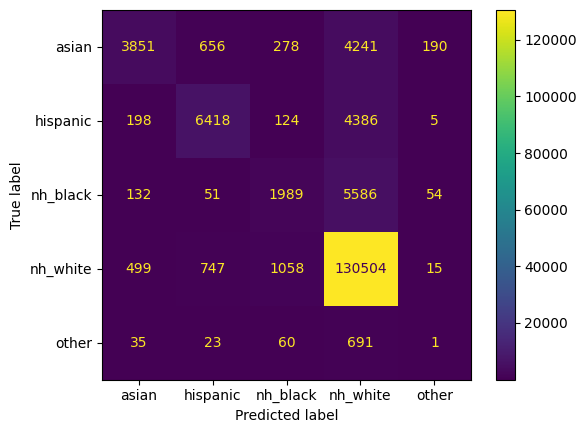

In [100]:
# prompt: Create classification report for column ethni_act and preds

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

actual = merged_df['ethni_act']
predictions = merged_df['preds']

cm = confusion_matrix(actual, predictions, labels=all_categories)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_categories)
disp.plot()

print(classification_report(merged_df['ethni_act'], merged_df['preds']))

In [126]:
# accuracy for each class
correct = merged_df[merged_df['ethni_act'] == merged_df['preds']]['ethni_act'].value_counts().to_dict()
total = merged_df['ethni_act'].value_counts().to_dict()

for k, v in correct.items():
    print(f'{k}: {v/total[k]*100:.2f}%')


nh_white: 98.25%
hispanic: 57.66%
asian: 41.79%
nh_black: 25.46%
other: 0.12%
